In [ ]:
!pip install matplotlib numba numpy pandas

In [2]:
import numpy as np
import pandas as pd
import random
from time import perf_counter
import matplotlib.pyplot as plt
import numba

## Method 1: .apply() with no optimization

In [2]:
def calculate_ratio(window_data):
    negative_returns = window_data[window_data < 0]
    return window_data.mean() / negative_returns.std()

def calculate_sortino_ratio_apply(time_series, window=30):    
    return time_series.rolling(window).apply(calculate_ratio)

## Method 2: .apply() with numba

In [3]:
def calculate_ratio(window_data):
    negative_returns = window_data[window_data < 0]
    return window_data.mean() / negative_returns.std()

def calculate_sortino_ratio_apply_compiled(time_series, window=30):    
    return time_series.rolling(window).apply(
        calculate_ratio,
        engine="numba",
        engine_kwargs={"nopython": True, "nogil": True, "parallel": False},
        raw=True)

# Warmstart to compile. JIT compilation will cause performance overhead
_ = calculate_sortino_ratio_apply_compiled(pd.Series([1,2,3]))

## Method 3: Prebuilt aggregation approach

In [4]:
def calculate_sortino_ratio_prebuilt(time_series, window=30):
    rolling_mean = time_series.rolling(window).mean()
    
    # create mask for negative returns
    negative_mask = pd.Series(np.zeros(len(time_series)), index=time_series.index)
    negative_mask[time_series < 0] = 1
    
    negative_count = negative_mask.rolling(window).sum()
    negative_returns = time_series * negative_mask
    
    sum_negative = negative_returns.rolling(window).sum()
    sum_squared_negative = (negative_returns ** 2).rolling(window).sum()
    
    variance_negative = (sum_squared_negative - sum_negative) / negative_count
    downside_deviation = np.sqrt(variance_negative)
    
    sortino_ratio = rolling_mean / downside_deviation
    
    return sortino_ratio

In [5]:
def run_performance_test():
    dataset_sizes = np.arange(1000, 20000 + 1, 1000)
    pure_apply_times = []
    apply_compiled_times = []
    prebuilt_aggregation_times = []
    
    iterations = 30
    
    for size in dataset_sizes:
        returns = pd.Series([random.uniform(-5, 5) for _ in range(size)])
        
        start_time = perf_counter()
        for _ in range(iterations):
            calculate_sortino_ratio_apply(returns)
        pure_apply_time = (perf_counter() - start_time) / iterations
        pure_apply_times.append(pure_apply_time)
        
        start_time = perf_counter()
        for _ in range(iterations):
            calculate_sortino_ratio_apply_compiled(returns)
        apply_compiled_time = (perf_counter() - start_time) / iterations
        apply_compiled_times.append(apply_compiled_time)
        
        start_time = perf_counter()
        for _ in range(iterations):
            calculate_sortino_ratio_prebuilt(returns)
        prebuilt_aggregation_time = (perf_counter() - start_time) / iterations
        prebuilt_aggregation_times.append(prebuilt_aggregation_time)
    
    return dataset_sizes, pure_apply_times, apply_compiled_times, prebuilt_aggregation_times

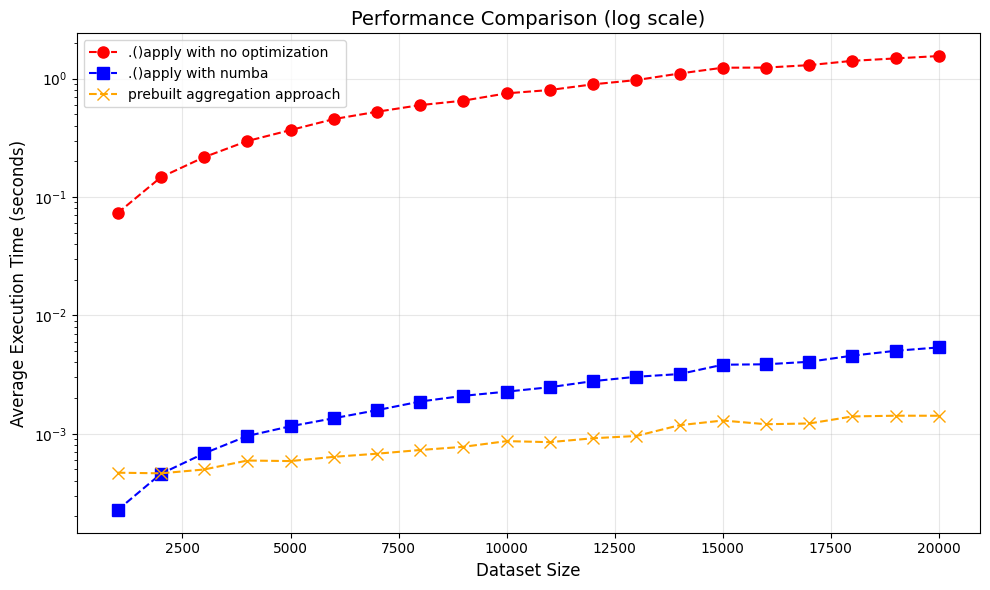

In [6]:
def performance_comparison(sizes, pure_apply_times, apply_compiled_times, prebuilt_aggregation_times):
    fig, ax1 = plt.subplots(figsize=(10, 6))

    ax1.plot(sizes, pure_apply_times, 'red', linestyle='--', marker='o', label='.()apply with no optimization', markersize=8)
    ax1.plot(sizes, apply_compiled_times, 'blue', linestyle='--', marker='s', label='.()apply with numba', markersize=8)
    ax1.plot(sizes, prebuilt_aggregation_times, 'orange', linestyle='--', marker='x', label='prebuilt aggregation approach', markersize=8)
    
    ax1.set_xlabel('Dataset Size', fontsize=12)
    ax1.set_ylabel('Average Execution Time (seconds)', fontsize=12)
    ax1.set_title('Performance Comparison (log scale)', fontsize=14)
    ax1.set_yscale('log')
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc='upper left')
    
    plt.tight_layout()
    return fig

sizes, pure_apply_times, apply_compiled_times, prebuilt_aggregation_times = run_performance_test()
fig = performance_comparison(sizes, pure_apply_times, apply_compiled_times, prebuilt_aggregation_times)
plt.show()

In [11]:
# profile data
preturns = pd.Series([random.uniform(-5, 5) for _ in range(50000)])

## Profiling approach #1

In [12]:
%prun -l 10 calculate_sortino_ratio_apply(preturns)

         28834368 function calls (28234690 primitive calls) in 10.900 seconds

   Ordered by: internal time
   List reduced from 381 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
5946762/5846815    0.789    0.000    1.313    0.000 {built-in method builtins.isinstance}
   349798    0.374    0.000    0.374    0.000 {method 'reduce' of 'numpy.ufunc' objects}
   149913    0.337    0.000    0.483    0.000 generic.py:6236(__finalize__)
    49971    0.293    0.000    0.705    0.000 nanops.py:954(nanvar)
    49973    0.255    0.000    1.745    0.000 series.py:389(__init__)
   999427    0.240    0.000    0.533    0.000 generic.py:42(_instancecheck)
   249857    0.199    0.000    0.467    0.000 generic.py:6301(__setattr__)
1299304/899525    0.197    0.000    0.286    0.000 {built-in method builtins.len}
   999427    0.193    0.000    0.283    0.000 generic.py:37(_check)
   149915    0.179    0.000    0.212    0.000 generic.py:278(__init__)

## Profiling approach #2

In [13]:
%prun -l 10 calculate_sortino_ratio_apply_compiled(preturns)

         868 function calls (857 primitive calls) in 0.018 seconds

   Ordered by: internal time
   List reduced from 241 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.014    0.014    0.014    0.014 rolling.py:601(calc)
        1    0.001    0.001    0.001    0.001 {method 'execute' of 'sqlite3.Connection' objects}
        2    0.001    0.000    0.001    0.000 {method '__exit__' of 'sqlite3.Connection' objects}
        1    0.000    0.000    0.017    0.017 rolling.py:1471(apply)
        1    0.000    0.000    0.003    0.003 decorator.py:232(fun)
        5    0.000    0.000    0.000    0.000 attrsettr.py:66(_get_attr_opt)
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}
      2/1    0.000    0.000    0.000    0.000 {method 'control' of 'select.kqueue' objects}
       14    0.000    0.000    0.000    0.000 socket.py:623(send)
        1    0.000    0.000    0.017    0.017 

## Profiling approach #3

In [14]:
%prun -l 10 calculate_sortino_ratio_prebuilt(preturns)

         3501 function calls (3420 primitive calls) in 0.007 seconds

   Ordered by: internal time
   List reduced from 417 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        4    0.001    0.000    0.002    0.000 rolling.py:601(calc)
        1    0.000    0.000    0.007    0.007 97548724.py:1(calculate_sortino_ratio_prebuilt)
        1    0.000    0.000    0.000    0.000 arraylike.py:253(array_ufunc)
        2    0.000    0.000    0.000    0.000 {method '__exit__' of 'sqlite3.Connection' objects}
        1    0.000    0.000    0.000    0.000 blocks.py:214(is_extension)
        1    0.000    0.000    0.002    0.002 rolling.py:1605(mean)
        1    0.000    0.000    0.000    0.000 generic.py:563(_construct_axes_dict)
        8    0.000    0.000    0.000    0.000 _methods.py:100(_clip)
        1    0.000    0.000    0.000    0.000 putmask.py:62(putmask_without_repeat)
        4    0.000    0.000    0.000    0.000 objects.py:96(